#### Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.ensemble import RandomForestClassifier
#!pip install pycaret
from pycaret.classification import *
from pycaret.regression import *

# Importing the data (if not *.MLReady.csv) 
### If you have *.MLReady.csv file [click here](#MLReady)

In [2]:
data=pd.read_csv("data/Quicken14.csv")
data.head()

,Unnamed: 0,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,...,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,fmacRate,fredRate,rateDiff,rateDiffPct,rank,deal
0,11186790,100103942980,1,QUICKEN LOANS INC.,4.750,84000,2014-02-01,2014-04-01,53.0,53.0,...,0.0,733.0,733.0,733.0,4.32,2.67,0.430,0.099537,4.0,Premium
1,11186791,100228548052,1,QUICKEN LOANS INC.,4.875,137000,2014-02-01,2014-04-01,69.0,69.0,...,0.0,799.0,799.0,799.0,4.32,2.67,0.555,0.128472,4.0,Premium
2,11186795,100642527357,1,QUICKEN LOANS INC.,4.750,459000,2014-02-01,2014-04-01,77.0,77.0,...,0.0,754.0,752.0,753.0,4.32,2.67,0.430,0.099537,4.0,Premium
3,11186802,101224052577,1,QUICKEN LOANS INC.,4.250,219000,2014-02-01,2014-04-01,77.0,77.0,...,0.0,766.0,766.0,766.0,4.32,2.67,-0.070,-0.016204,3.0,Discount
4,11186803,101333352654,1,QUICKEN LOANS INC.,5.250,92000,2014-02-01,2014-04-01,80.0,80.0,...,0.0,707.0,707.0,707.0,4.32,2.67,0.930,0.215278,4.0,Premium


## Clean non-"MLReady.csv"input file steps 
#### if using 'MLReady.csv' skip to cell [Model building using Pycaret Library](#PyCaretStart) 

In [3]:
data.shape

(293383, 27)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        293383 non-null  int64  
 1   loanIdentifier    293383 non-null  int64  
 2   origChannel       293383 non-null  int64  
 3   sellerName        293383 non-null  object 
 4   origIntRate       293383 non-null  float64
 5   origUPB           293383 non-null  int64  
 6   origDate          293383 non-null  object 
 7   firstPmtDate      293383 non-null  object 
 8   origLTV           293383 non-null  float64
 9   origCLTV          293383 non-null  float64
 10  numBorrowers      293383 non-null  float64
 11  origDebtIncRatio  293383 non-null  float64
 12  borrCreditScore   293383 non-null  float64
 13  loanPurp          293383 non-null  int64  
 14  propState         293383 non-null  object 
 15  zipCode           293383 non-null  int64  
 16  pMIperct          29

In [5]:
data.rename(columns={'Unnamed: 0':'namedCol'}, inplace=True )

In [6]:
sellerNames = data['sellerName'].unique()
statesList = data['propState'].unique()

In [7]:
# Make copy of the column to map from strings to integers
data['bankNumber'] = data['sellerName']
# Coerce the new column to category type
data['bankNumber'] = data['bankNumber'].astype('category')
# Convert the new column to integers for each unique string value
data['bankNumber'] = data['bankNumber'].cat.codes
# Capture the mapping to a dictionary
sellerNameMap = pd.Series(data.sellerName.values,index=data.bankNumber).to_dict()
# Drop original column leaving only the integer column for ML purposes
data.drop(columns=['sellerName'],inplace=True)
print(sorted(sellerNameMap.items()))

[(0, 'QUICKEN LOANS INC.')]


In [8]:
# Make copy of the column to map from strings to integers
data['stateNumber'] = data['propState']
# Coerce the new column to category type
data['stateNumber'] = data['stateNumber'].astype('category')
# Convert the new column to integers for each unique string value
data['stateNumber'] = data['stateNumber'].cat.codes
# Capture the mapping to a dictionary
statePropMap = pd.Series(data.propState.values,index=data.stateNumber).to_dict()
# Drop original column leaving only the integer column for ML purposes
data.drop(columns=['propState'],inplace=True)
print(sorted(statePropMap.items()))

[(0, 'AK'), (1, 'AL'), (2, 'AR'), (3, 'AZ'), (4, 'CA'), (5, 'CO'), (6, 'CT'), (7, 'DC'), (8, 'DE'), (9, 'FL'), (10, 'GA'), (11, 'HI'), (12, 'IA'), (13, 'ID'), (14, 'IL'), (15, 'IN'), (16, 'KS'), (17, 'KY'), (18, 'LA'), (19, 'MA'), (20, 'MD'), (21, 'ME'), (22, 'MI'), (23, 'MN'), (24, 'MO'), (25, 'MS'), (26, 'MT'), (27, 'NC'), (28, 'ND'), (29, 'NE'), (30, 'NH'), (31, 'NJ'), (32, 'NM'), (33, 'NV'), (34, 'NY'), (35, 'OH'), (36, 'OK'), (37, 'OR'), (38, 'PA'), (39, 'RI'), (40, 'SC'), (41, 'SD'), (42, 'TN'), (43, 'TX'), (44, 'UT'), (45, 'VA'), (46, 'VT'), (47, 'WA'), (48, 'WI'), (49, 'WV'), (50, 'WY')]


In [9]:
#Checking for missing values
data.isnull().sum()

namedCol            0
loanIdentifier      0
origChannel         0
origIntRate         0
origUPB             0
origDate            0
firstPmtDate        0
origLTV             0
origCLTV            0
numBorrowers        0
origDebtIncRatio    0
borrCreditScore     0
loanPurp            0
zipCode             0
pMIperct            0
mortInsType         0
bestCreditScore     0
worstCreditScore    0
avgCreditScore      0
fmacRate            0
fredRate            0
rateDiff            0
rateDiffPct         0
rank                0
deal                0
bankNumber          0
stateNumber         0
dtype: int64

In [10]:
#Checking datatypes of individual feature
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   namedCol          293383 non-null  int64  
 1   loanIdentifier    293383 non-null  int64  
 2   origChannel       293383 non-null  int64  
 3   origIntRate       293383 non-null  float64
 4   origUPB           293383 non-null  int64  
 5   origDate          293383 non-null  object 
 6   firstPmtDate      293383 non-null  object 
 7   origLTV           293383 non-null  float64
 8   origCLTV          293383 non-null  float64
 9   numBorrowers      293383 non-null  float64
 10  origDebtIncRatio  293383 non-null  float64
 11  borrCreditScore   293383 non-null  float64
 12  loanPurp          293383 non-null  int64  
 13  zipCode           293383 non-null  int64  
 14  pMIperct          293383 non-null  float64
 15  mortInsType       293383 non-null  float64
 16  bestCreditScore   29

In [11]:
#Dropping columns we don't want
data.drop(['loanIdentifier','namedCol', 'firstPmtDate', 'bestCreditScore', 'worstCreditScore', 'rateDiff',
           'borrCreditScore','bankNumber'],1,inplace=True)

In [12]:
data.head()

,origChannel,origIntRate,origUPB,origDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,mortInsType,avgCreditScore,fmacRate,fredRate,rateDiffPct,rank,deal,bankNumber,stateNumber
0,1,4.750,84000,2014-02-01,53.0,53.0,1.0,44.0,1,724,0.0,0.0,733.0,4.32,2.67,0.099537,4.0,Premium,0,2
1,1,4.875,137000,2014-02-01,69.0,69.0,1.0,47.0,1,802,0.0,0.0,799.0,4.32,2.67,0.128472,4.0,Premium,0,5
2,1,4.750,459000,2014-02-01,77.0,77.0,2.0,42.0,2,109,0.0,0.0,753.0,4.32,2.67,0.099537,4.0,Premium,0,34
3,1,4.250,219000,2014-02-01,77.0,77.0,1.0,22.0,2,956,0.0,0.0,766.0,4.32,2.67,-0.016204,3.0,Discount,0,4
4,1,5.250,92000,2014-02-01,80.0,80.0,1.0,44.0,1,760,0.0,0.0,707.0,4.32,2.67,0.215278,4.0,Premium,0,43


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   origChannel       293383 non-null  int64  
 1   origIntRate       293383 non-null  float64
 2   origUPB           293383 non-null  int64  
 3   origDate          293383 non-null  object 
 4   origLTV           293383 non-null  float64
 5   origCLTV          293383 non-null  float64
 6   numBorrowers      293383 non-null  float64
 7   origDebtIncRatio  293383 non-null  float64
 8   loanPurp          293383 non-null  int64  
 9   zipCode           293383 non-null  int64  
 10  pMIperct          293383 non-null  float64
 11  mortInsType       293383 non-null  float64
 12  avgCreditScore    293383 non-null  float64
 13  fmacRate          293383 non-null  float64
 14  fredRate          293383 non-null  float64
 15  rateDiffPct       293383 non-null  float64
 16  rank              29

## Engineer originDate into Date features

In [14]:
data['origDate'] = pd.to_datetime(data['origDate'])

In [15]:
data['origYear'] = data['origDate'].dt.year
data['origMonth'] = data['origDate'].dt.month
data['origWeek'] = data['origDate'].dt.week
# data['origDay'] = data['origDate'].dt.day
# data['origDayOfWeek'] = data['origDate'].dt.dayofweek

In [16]:
data[['origYear','origMonth','origWeek']].head()

,origYear,origMonth,origWeek
0,2014,2,5
1,2014,2,5
2,2014,2,5
3,2014,2,5
4,2014,2,5


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   origChannel       293383 non-null  int64         
 1   origIntRate       293383 non-null  float64       
 2   origUPB           293383 non-null  int64         
 3   origDate          293383 non-null  datetime64[ns]
 4   origLTV           293383 non-null  float64       
 5   origCLTV          293383 non-null  float64       
 6   numBorrowers      293383 non-null  float64       
 7   origDebtIncRatio  293383 non-null  float64       
 8   loanPurp          293383 non-null  int64         
 9   zipCode           293383 non-null  int64         
 10  pMIperct          293383 non-null  float64       
 11  mortInsType       293383 non-null  float64       
 12  avgCreditScore    293383 non-null  float64       
 13  fmacRate          293383 non-null  float64       
 14  fred

In [18]:
data.groupby('origMonth').size()

origMonth
1     26532
2     27665
3     22885
4     18824
5     20706
6     20209
7     21515
8     26552
9     27395
10    27478
11    25566
12    28056
dtype: int64

In [19]:
data.drop(columns=['origDate'],inplace=True)

In [31]:
data.shape

(293383, 22)

In [32]:
data.columns

Index(['origChannel', 'origIntRate', 'origUPB', 'origLTV', 'origCLTV',
       'numBorrowers', 'origDebtIncRatio', 'loanPurp', 'zipCode', 'pMIperct',
       'mortInsType', 'avgCreditScore', 'fmacRate', 'fredRate', 'rateDiffPct',
       'rank', 'deal', 'bankNumber', 'stateNumber', 'origYear', 'origMonth',
       'origWeek'],
      dtype='object')

In [33]:
data['origMonth'].unique()

array([ 2,  1,  3,  6,  4,  5,  8,  9,  7, 11, 10, 12], dtype=int64)

## Filter data by year

In [34]:
df18 = data[data['origYear'] >= 2013]


In [35]:
df18.shape

(293383, 22)

In [36]:
df18.origMonth.unique()

array([ 2,  1,  3,  6,  4,  5,  8,  9,  7, 11, 10, 12], dtype=int64)

In [37]:
df18.deal.unique()

array(['Premium', 'Discount', 'Par'], dtype=object)

In [38]:
df18 = df18[~((df18['origYear'] == 2013) & (df18['origMonth'] < 10))]

In [39]:
df18.shape

(293383, 22)

In [40]:
df18.origYear.unique()

array([2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [41]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293383 entries, 0 to 293382
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   origChannel       293383 non-null  int64  
 1   origIntRate       293383 non-null  float64
 2   origUPB           293383 non-null  int64  
 3   origLTV           293383 non-null  float64
 4   origCLTV          293383 non-null  float64
 5   numBorrowers      293383 non-null  float64
 6   origDebtIncRatio  293383 non-null  float64
 7   loanPurp          293383 non-null  int64  
 8   zipCode           293383 non-null  int64  
 9   pMIperct          293383 non-null  float64
 10  mortInsType       293383 non-null  float64
 11  avgCreditScore    293383 non-null  float64
 12  fmacRate          293383 non-null  float64
 13  fredRate          293383 non-null  float64
 14  rateDiffPct       293383 non-null  float64
 15  rank              293383 non-null  float64
 16  deal              29

In [42]:
#df = df18.convert_dtypes()

## Coerce the columns into interger dtypes

In [43]:
df18['origUPB'] = df18['origUPB'].astype(int)
df18['origLTV'] = df18['origLTV'].astype(int)
df18['origDebtIncRatio'] = df18['origDebtIncRatio'].astype(int)
df18['avgCreditScore'] = df18['avgCreditScore'].astype(int)
df18['numBorrowers'] = df18['numBorrowers'].astype(int)
df18['rank'] = df18['rank'].astype(int)

In [44]:
df18 = df18.drop(['origCLTV'], axis=1)

In [45]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293383 entries, 0 to 293382
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   origChannel       293383 non-null  int64  
 1   origIntRate       293383 non-null  float64
 2   origUPB           293383 non-null  int32  
 3   origLTV           293383 non-null  int32  
 4   numBorrowers      293383 non-null  int32  
 5   origDebtIncRatio  293383 non-null  int32  
 6   loanPurp          293383 non-null  int64  
 7   zipCode           293383 non-null  int64  
 8   pMIperct          293383 non-null  float64
 9   mortInsType       293383 non-null  float64
 10  avgCreditScore    293383 non-null  int32  
 11  fmacRate          293383 non-null  float64
 12  fredRate          293383 non-null  float64
 13  rateDiffPct       293383 non-null  float64
 14  rank              293383 non-null  int32  
 15  deal              293383 non-null  object 
 16  bankNumber        29

In [46]:
df18.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,mortInsType,...,fmacRate,fredRate,rateDiffPct,rank,deal,bankNumber,stateNumber,origYear,origMonth,origWeek
0,1,4.750,84000,53,1,44,1,724,0.0,0.0,...,4.32,2.67,0.099537,4,Premium,0,2,2014,2,5
1,1,4.875,137000,69,1,47,1,802,0.0,0.0,...,4.32,2.67,0.128472,4,Premium,0,5,2014,2,5
2,1,4.750,459000,77,2,42,2,109,0.0,0.0,...,4.32,2.67,0.099537,4,Premium,0,34,2014,2,5
3,1,4.250,219000,77,1,22,2,956,0.0,0.0,...,4.32,2.67,-0.016204,3,Discount,0,4,2014,2,5
4,1,5.250,92000,80,1,44,1,760,0.0,0.0,...,4.32,2.67,0.215278,4,Premium,0,43,2014,2,5


In [48]:
df18 = df18.drop(columns = ['origWeek','bankNumber'])

In [49]:
df18.columns

Index(['origChannel', 'origIntRate', 'origUPB', 'origLTV', 'numBorrowers',
       'origDebtIncRatio', 'loanPurp', 'zipCode', 'pMIperct', 'mortInsType',
       'avgCreditScore', 'fmacRate', 'fredRate', 'rateDiffPct', 'rank', 'deal',
       'stateNumber', 'origYear', 'origMonth'],
      dtype='object')

In [50]:
df18['deal'] = df18['deal'].astype('category')
# Convert the new column to integers for each unique string value
df18['deal'] = df18['deal'].cat.codes

# Save the output as a *.MLReady.csv file for later use

In [47]:
df18.to_csv('data/FannieAcq2000-19FMac30samp100QuickenMlReady14cut.csv')

<a id='MLReady'></a>
# Load *.MLReady.csv file below (otherwise comment out)

In [64]:
df18 = pd.read_csv('data/FannieAcq2000-19FMac30samp100QuickenMlReady14cut.csv')

In [65]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        293383 non-null  int64  
 1   origChannel       293383 non-null  int64  
 2   origIntRate       293383 non-null  float64
 3   origUPB           293383 non-null  int64  
 4   origLTV           293383 non-null  int64  
 5   numBorrowers      293383 non-null  int64  
 6   origDebtIncRatio  293383 non-null  int64  
 7   loanPurp          293383 non-null  int64  
 8   zipCode           293383 non-null  int64  
 9   pMIperct          293383 non-null  float64
 10  mortInsType       293383 non-null  float64
 11  avgCreditScore    293383 non-null  int64  
 12  fmacRate          293383 non-null  float64
 13  fredRate          293383 non-null  float64
 14  rateDiffPct       293383 non-null  float64
 15  rank              293383 non-null  int64  
 16  deal              29

In [68]:
#Dropping columns we don't want (if you need to)
df18.drop(['Unnamed: 0','bankNumber'],1,inplace=True)

In [69]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293383 entries, 0 to 293382
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   origChannel       293383 non-null  int64  
 1   origIntRate       293383 non-null  float64
 2   origUPB           293383 non-null  int64  
 3   origLTV           293383 non-null  int64  
 4   numBorrowers      293383 non-null  int64  
 5   origDebtIncRatio  293383 non-null  int64  
 6   loanPurp          293383 non-null  int64  
 7   zipCode           293383 non-null  int64  
 8   pMIperct          293383 non-null  float64
 9   mortInsType       293383 non-null  float64
 10  avgCreditScore    293383 non-null  int64  
 11  fmacRate          293383 non-null  float64
 12  fredRate          293383 non-null  float64
 13  rateDiffPct       293383 non-null  float64
 14  rank              293383 non-null  int64  
 15  deal              293383 non-null  object 
 16  stateNumber       29

<a id='PyCaretStart'></a>
# Model building using Pycaret Library

In [59]:
models=setup(df18, target = 'rateDiffPct',
             feature_interaction=True, feature_ratio=True,
             polynomial_features=True,
            numeric_features = ['origUPB','origLTV','numBorrowers','origDebtIncRatio',\
                               'avgCreditScore'],
            ignore_features = ['origIntRate','rank','deal'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4267
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(293383, 19)"
4,Missing Values,False
5,Numeric Features,14
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [60]:
# %tb
# models=setup(df18, target = 'deal', session_id = 123,\
#              normalize = True, normalize_method = 'zscore',
#              categorical_features = ['origChannel','loanPurp','mortInsType',
#                                      'zipCode'],
#              numeric_features =['origUPB','origLTV','origDebtIncRatio','pMIperct',
#                                'fmacRate','fredRate','numborrowers','origYear','origMonth'],
#             ignore_features = ['origIntRate','rateDiffPct','rank','bankNumber'])

In [61]:
model_results=compare_models(blacklist = ['tr','ransac'], fold = 5, turbo=True)
model_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.043900,0.003200,0.056500,0.560000,0.046600,0.505200
1,Light Gradient Boosting Machine,0.044200,0.003200,0.056900,0.553900,0.046800,0.500800
2,Extreme Gradient Boosting,0.045600,0.003400,0.058300,0.531100,0.047800,0.521000
3,Gradient Boosting Regressor,0.045600,0.003400,0.058300,0.531000,0.047800,0.519600
4,Random Forest,0.046100,0.003500,0.059200,0.516500,0.048500,0.514100
5,Extra Trees Regressor,0.046200,0.003500,0.059500,0.511600,0.048800,0.516800
6,Linear Regression,0.049600,0.004000,0.063100,0.451000,0.051600,0.584900
7,Bayesian Ridge,0.049600,0.004000,0.063100,0.450400,0.051600,0.586500
8,Ridge Regression,0.050500,0.004100,0.064000,0.436000,0.052200,0.606200
9,AdaBoost Regressor,0.053300,0.004500,0.066800,0.384200,0.053400,0.652600


In [62]:
catboost =create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0443,0.0032,0.0566,0.5552,0.0469,0.5017
1,0.0435,0.0032,0.0569,0.5402,0.0467,0.4806
2,0.0439,0.0032,0.0563,0.5620,0.0468,0.5017
3,0.0445,0.0033,0.0573,0.5553,0.0471,0.5875
4,0.0438,0.0032,0.0564,0.5499,0.0466,0.6118
5,0.0430,0.0030,0.0552,0.5821,0.0452,0.4651
6,0.0435,0.0031,0.0558,0.5682,0.0464,0.5512
7,0.0434,0.0031,0.0556,0.5859,0.0457,0.4397
8,0.0451,0.0034,0.0580,0.5540,0.0472,0.4498
9,0.0440,0.0032,0.0563,0.5539,0.0464,0.4627


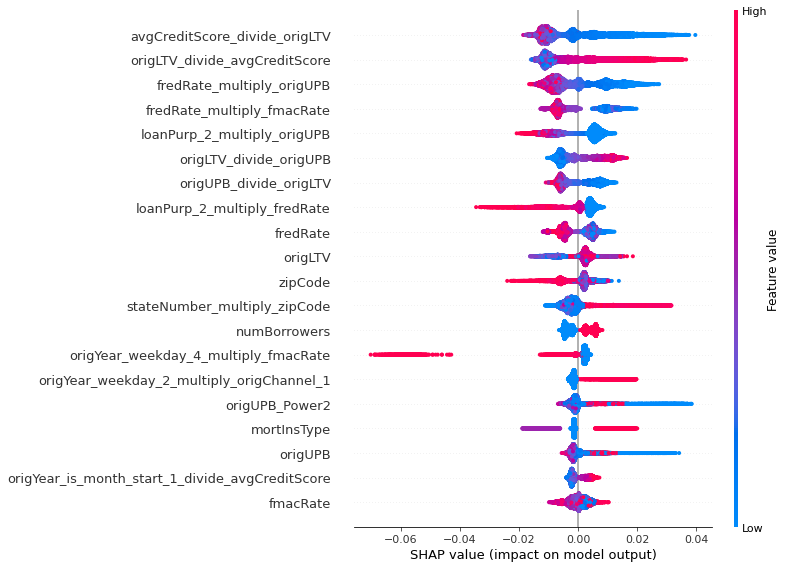

In [63]:
interpret_model(catboost)

In [57]:
#interpret_model(estimator=logreg_model, plot='correlation')

NameError: name 'logreg_model' is not defined

In [ ]:
#interpret_model(estimator=logreg_model, plot='reason')

In [ ]:
#logreg_model2=create_model('xgboost')

In [ ]:
#plot_model(estimator=logreg_model2, plot='feature')

In [ ]:
#plot_model(estimator=logreg_model2)

In [ ]:
#tunned_logreg_model=tune_model('catboost')

In [ ]:
#interpret_model(estimator=tunned_logreg_model,plot='summary')

In [ ]:
#plot_model(estimator=tunned_logreg_model,plot='feature')